# Document Similarity with BERT

### Because there is a token limit with the BERT model, it's sometimes inconvenient to vectorize long documents. In this case, we'd like to convert entire Twitter account streams to a single vector in order to compare the similarity of rhetoric across numerous accounts. This approach involves retrieving the average of the [CLS] vector of all the tweets of a given account. This provides a rough approximation of where the account exists in relative vector space. 

In [1]:
import ast
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import torch
import sklearn

In [ ]:
!pip install transformers

In [3]:
from transformers import AutoTokenizer, AutoModel

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
rus_df = pd.read_csv('/content/drive/MyDrive/NLP_stuff/all_rus_tweets.csv')
usa_df = pd.read_csv('/content/drive/MyDrive/NLP_stuff/all_usa_tweets.csv')

In [11]:
### This creates an average of CLS token vectors to represent the entire twitter account.

def make_BERT_average(df,network_level,file_name):
    countries = list(df.Country.unique())
    CLS_means_list = []
    for country in tqdm(countries):
        batch = pd.DataFrame(df[df.Country==country].clean_text.str.lower()).dropna()
        total_batches = int(len(batch)/100)
        batch_array = np.ones([1,768])
        for idx in tqdm(range(total_batches)):
            start_row = idx * 100
            end_row = (idx+1) * 100
            sub_batch = batch.iloc[start_row:end_row]
            tokenized = sub_batch['clean_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
            max_len = 0

            for i in tokenized.values:
                if len(i) > max_len:
                    max_len = len(i)

            padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
            attention_mask = np.where(padded != 0, 1, 0)
            input_ids = torch.tensor(padded)  
            attention_mask = torch.tensor(attention_mask)

            with torch.no_grad():
                last_hidden_states = model(input_ids, attention_mask=attention_mask)
            
            features = last_hidden_states[0][:,0,:].numpy()
            batch_array = np.concatenate([batch_array,features])
        
        batch_array = batch_array[1:]
        x = batch_array.mean(0)
        CLS_means_list.append(x)
    dff = pd.DataFrame(CLS_means_list)
    dff['country'] = countries
    dff['network'] = network_level
    return dff.to_csv(file_name)

In [12]:
#make_BERT_average(rus_df,'RUS','/content/drive/MyDrive/NLP_stuff/BERT_sentence_averages_RUS.csv')

In [13]:
#make_BERT_average(usa_df,'USA','/content/drive/MyDrive/NLP_stuff/BERT_sentence_averages_USA.csv')

In [14]:
# dff_usa = pd.read_csv('/content/drive/MyDrive/NLP_stuff/BERT_sentence_averages_USA.csv')
# dff_usa = dff_usa.dropna()
# dff_rus = pd.read_csv('/content/drive/MyDrive/NLP_stuff/BERT_sentence_averages_USA.csv')
# dff_rus = dff_rus.dropna()
# dff = pd.concat([dff_usa,dff_rus])

In [15]:
bert_df = pd.read_csv('/content/drive/MyDrive/NLP_stuff/BERT_sentence_averages.csv')

In [121]:
bert_df.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,760,761,762,763,764,765,766,767,country,network
0,0,-0.123971,-0.178971,-0.192037,-0.233024,-0.164525,-0.263235,0.311375,0.311862,-0.100275,...,0.139107,-0.350028,0.246597,-0.173546,-0.116812,-0.146814,0.393668,0.208418,AFGHANISTAN,USA
1,1,-0.105314,-0.057390,-0.143064,-0.217163,-0.111287,-0.090015,0.370276,0.184201,-0.157910,...,0.123093,-0.302059,0.228413,-0.211163,-0.071461,-0.011721,0.318853,0.339293,ALBANIA,USA
2,2,-0.119199,-0.061916,-0.182698,-0.261573,-0.138362,-0.218713,0.216866,0.316219,-0.121005,...,0.047507,-0.301291,0.201654,-0.232406,-0.085704,-0.175381,0.420121,0.264635,ALGERIA,USA
3,3,-0.107841,-0.071920,0.022015,-0.048925,0.161376,-0.186643,0.276503,0.415142,-0.045163,...,0.111553,-0.355098,0.082370,-0.116701,-0.097542,-0.180433,0.326124,0.412436,ARGENTINA,USA
4,4,-0.113935,-0.072479,-0.117625,-0.127208,-0.085333,-0.217633,0.259375,0.335546,-0.147808,...,0.075103,-0.303854,0.205819,-0.184111,-0.048244,-0.133226,0.427434,0.337109,ARMENIA,USA


In [17]:
bert_df.shape

(292, 771)

In [103]:
### Mahalanobis distance is a useful approach to identify outlier vectors in a set.

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

import scipy as sp
countries = ['afghanistan', 'albania', 'algeria', 'angola', 'argentina', 'armenia', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bolivia', 'bosnia', 'botswana', 'brazil', 'brunei', 'bulgaria', 'burkina', 'burundi', 'cabo', 'cambodia', 'cameroon', 'canada', 'chad', 'chile', 'china', 'colombia', 'comoros', 'congo', 'costa', 'côte', 'croatia', 'cuba', 'cyprus', 'czechia', 'denmark', 'djibouti', 'dominican', 'ecuador', 'egypt', 'elsalvador', 'equatorialguinea', 'eritrea', 'estonia', 'eswatini', 'ethiopia', 'fiji', 'finland', 'france', 'gabon', 'georgia', 'germany', 'ghana', 'greece', 'guatemala', 'guineabissau', 'guinea', 'guyana', 'haiti','vatican','honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'iraq', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', 'northkorea','southkorea', 'kuwait', 'kyrgyzstan', 'lao', 'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'lithuania', 'luxembourg', 'madagascar', 'malawi', 'malaysia', 'mali', 'malta', 'mauritania', 'mauritius', 'mexico', 'moldova', 'mongolia', 'montenegro', 'morocco', 'mozambique', 'myanmar', 'nepal', 'netherlands', 'newzealand', 'nicaragua', 'niger', 'nigeria', 'norway', 'oman', 'pakistan', 'palau', 'palestine', 'panama', 'paraguay', 'peru', 'philippines', 'poland', 'portugal', 'qatar', 'romania', 'russia', 'rwanda', 'saudi', 'saudiarabia','senegal', 'serbia', 'seychelles', 'sierra', 'singapore', 'slovakia', 'slovenia', 'somalia', 'spain', 'srilanka', 'sudan', 'suriname', 'sweden', 'switzerland', 'syria', 'tajikistan', 'tanzania', 'thailand', 'togo', 'trinidad', 'tunisia', 'turkey', 'turkmenistan', 'uganda', 'ukraine', 'uae', 'emirates', 'unitedstates', 'uruguay', 'uzbekistan', 'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe']
    
def get_mahalanobis_outlier_rank_BERT(df,network):
    dff = df[df['network']==network]
    columns = list(dff.columns)[1:-2]
    matrix = np.array(dff[columns])
    vector_df = pd.DataFrame(matrix)
    vector_df['network'] = network
    vector_df.index = dff.country
    cols = list(range(768))
    df_x = vector_df[cols]
    vector_df['mahalanobis'] = mahalanobis(x=df_x, data=vector_df[cols])
    
    return pd.DataFrame(vector_df[['network','mahalanobis']].sort_values(by='mahalanobis',ascending=True))

In [102]:
get_mahalanobis_outlier_rank_BERT(bert_df,'USA')[:10]

,network,mahalanobis
country,,
RUSSIAN FEDERATION,USA,-1963.742846
BELARUS,USA,-1703.544745
KYRGYZSTAN,USA,-1578.288703
SERBIA,USA,-1146.708953
AZERBAIJAN,USA,-998.951850
GABON,USA,-878.365623
CHINA,USA,-699.928473
UKRAINE,USA,-650.165341
SYRIAN ARAB REPUBLIC,USA,-528.324944


## Analysis
#### The Mahalanobis distance indicates which twitter accounts are the most intense outliers. As such, the above table indicates that the U.S. embassy in Russia is the most 'unusual' Twitter account of all the American embassies. As this data was collected before Russia's unprovoked invasion of Ukraine, the rhetoric of these Twitter accounts has likely shifted. 

In [51]:
from scipy.spatial import distance

Analyzing rhetorical similarity by country:

In [91]:
def most_similar_rhetoric(df, country,network):
  """
  country: AZERBAIJAN
  network: RUS or USA
  """
  cols_str = [str(x) for x in list(range(768))]
  cols = list(range(768))
  target = np.array(df[(df['country']==country) & (df['network']==network)][cols_str])
  #dff = df[df['network']==network]
  dff = df
  columns = list(dff.columns)[1:-2]
  matrix = np.array(dff[columns])
  vector_df = pd.DataFrame(matrix)
  vector_df['network'] = dff.network
  vector_df.index = dff.country
  
  df_x = vector_df[cols]

  vector_df['mahalanobis'] = distance.cdist(target, df_x, "cosine")[0] 

  return pd.DataFrame(vector_df[['network','mahalanobis']].sort_values(by='mahalanobis',ascending=True))

In [117]:
most_similar_rhetoric(bert_df, 'CHINA','USA').head(10)

,network,mahalanobis
country,,
CHINA,USA,0.000000
THAILAND,USA,0.050617
"KOREA, REPUBLIC OF",USA,0.072698
JAPAN,RUS,0.083818
TAJIKISTAN,USA,0.085865
KAZAKHSTAN,USA,0.086054
THAILAND,RUS,0.086508
OMAN,USA,0.089048
BULGARIA,USA,0.089503


The results above indicate that the U.S. embassy's rhetoric in Thailand is the most similar to that of China. 

In [116]:
most_similar_rhetoric(bert_df, 'RUSSIAN FEDERATION','USA').head(10)

,network,mahalanobis
country,,
RUSSIAN FEDERATION,USA,0.000000
KAZAKHSTAN,RUS,0.001898
ESTONIA,RUS,0.001965
"KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF",RUS,0.002400
TURKMENISTAN,RUS,0.002784
MONTENEGRO,RUS,0.002879
LATVIA,RUS,0.002921
ALGERIA,RUS,0.003189
NEPAL,RUS,0.003733


The results above indicate that the U.S. embassy in Russia has rhetoric (in English, at least) similar to that of the Russian embassy in Kazakhstan.

In [115]:
most_similar_rhetoric(bert_df, 'CHILE','USA').head(10)

,network,mahalanobis
country,,
CHILE,USA,0.000000
PARAGUAY,USA,0.001123
"BOLIVIA, PLURINATIONAL STATE OF",USA,0.001173
COSTA RICA,USA,0.001215
URUGUAY,USA,0.001272
ECUADOR,USA,0.001530
DOMINICAN REPUBLIC,USA,0.001742
EL SALVADOR,USA,0.002015
HONDURAS,RUS,0.002057


### With the function below, we can identify the countries in which the Russian and U.S. embassies are most rhetorically divergent. 

In [118]:
def most_divergent_rhetoric(df):
  """
  country: AZERBAIJAN
  network: RUS or USA
  """
  difference_list = []
  country_list = []
  cols_str = [str(x) for x in list(range(768))]
  cols = list(range(768))

  for country in list(set(df.country)):
    if len(df[df['country']==country]) == 2:
      target = np.array(df[(df['country']==country) & (df['network']=='USA')][cols_str])
      other_target = np.array(df[(df['country']==country) & (df['network']=='RUS')][cols_str])
      x = distance.cdist(target, other_target, "cosine")[0]
      difference_list.append(distance.cdist(target, other_target, "cosine")[0][0])
      country_list.append(country)
  
  dff = pd.DataFrame()
  dff['country'] = country_list
  dff['rhetorical_divergence'] = difference_list

  return pd.DataFrame(dff[['country','rhetorical_divergence']].sort_values(by='rhetorical_divergence',ascending=False))

In [119]:
rhetorical_divergence_df = most_divergent_rhetoric(bert_df)

In [120]:
rhetorical_divergence_df.head(15)

,country,rhetorical_divergence
26,CHINA,0.159700
56,LITHUANIA,0.130907
91,ARMENIA,0.110031
84,LATVIA,0.105453
76,ESTONIA,0.096285
116,UZBEKISTAN,0.090412
112,RUSSIAN FEDERATION,0.089570
105,SERBIA,0.088068
87,BULGARIA,0.087765
8,CUBA,0.087638


## Analysis:

The above table indicates that Russian and American embassies are most rhetorically divergent in China. This is unsurprising given that their respective bilateral relations with China are quite different, thereby validating the intuition of this mathematical approach. These results are qualitatively interesting, and can be visualized with UMAP.

In [ ]:
!pip install umap-learn

In [35]:
col = [str(x) for x in list(range(768))]

bert_vectors = bert_df[col]
labels = bert_df['network']

In [36]:
import umap
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(bert_vectors)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = labels
df_emb

,X,Y,label
0,9.614974,13.247363,USA
1,8.929202,11.863380,USA
2,8.234634,5.104928,USA
3,8.911706,14.297247,USA
4,9.780112,12.413893,USA
...,...,...,...
287,3.529148,9.867640,RUS
288,13.436786,6.697253,RUS
289,11.522364,8.184235,RUS
290,12.279021,9.926818,RUS


In [49]:
df_emb['color'] = ['purple' if df_emb.iloc[x]['label'] == 'RUS' else 'green' for x in range(len(df_emb))]

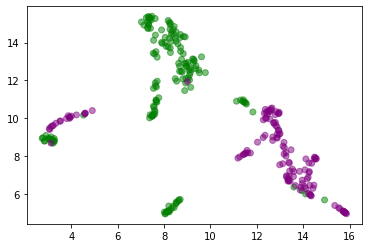

In [50]:
plt.scatter(df_emb["X"], df_emb["Y"], c=df_emb["color"], alpha=0.5)
plt.show()

### As expected, the flattened embeddings of entire embassy Twitter accounts show a distinction between American and Russian rhetoric when plotted in vector space.